Tests for Assessement week 5


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns    
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  

In [88]:


df = pd.read_csv('wines_SPA.csv')

# Initial data exploration

# I'm dropping duplicates right away to ensure the statistics are not distorted.
df = df.drop_duplicates()

# Describe numerical columns
print(df.describe())
print()
# Save numerical columns
numerical_columns = df.describe().columns

# I check the number of unique values in the remaining categorical column to understand their variability.
print("Categorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")

# Check for missing values
print("\nMissing Values")
print(df.isna().sum())

            rating   num_reviews        price         body      acidity
count  2048.000000   2048.000000  2048.000000  1777.000000  1777.000000
mean      4.401123    573.994629   135.242194     4.258863     2.921216
std       0.147023   1376.153171   272.178316     0.652836     0.334713
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.300000     58.000000    31.917947     4.000000     3.000000
50%       4.400000    141.000000    53.625000     4.000000     3.000000
75%       4.500000    485.500000   110.000000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000

Categorical Columns:
Unique values in 'winery': 480
Unique values in 'wine': 847
Unique values in 'year': 72
Unique values in 'country': 1
Unique values in 'region': 76
Unique values in 'type': 22

Missing Values
winery           0
wine             0
year             2
rating           0
num_reviews      0
country          0
region           0
price

In [89]:
# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'num_reviews'], axis=1)

# Drop missing values and drop duplicates again
df = df.dropna()

In [90]:


print(df.describe())

print("\nCategorical Columns:")
for column in df.columns:
    if column not in numerical_columns:
        print(f"Unique values in '{column}': {len(df[column].unique())}")

            rating        price         body      acidity
count  1775.000000  1775.000000  1775.000000  1775.000000
mean      4.411887   148.786017     4.258592     2.921690
std       0.150982   289.401877     0.652938     0.334181
min       4.200000     4.990000     2.000000     1.000000
25%       4.300000    33.015000     4.000000     3.000000
50%       4.400000    58.260000     4.000000     3.000000
75%       4.500000   125.000000     5.000000     3.000000
max       4.900000  3119.080000     5.000000     3.000000

Categorical Columns:
Unique values in 'winery': 425
Unique values in 'wine': 738
Unique values in 'year': 71
Unique values in 'region': 66
Unique values in 'type': 21


In [91]:
# Engineering data



# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])





In [92]:
# find unique values and their counts in categorical columns 
type_counts = df['type'].value_counts()
winery_counts = df['winery'].value_counts()
wine_counts = df['wine'].value_counts()
region_counts = df['region'].value_counts()

# from each remove the ones with less than 175 occurrences
type_to_keep = type_counts[type_counts >= 175].index
winery_to_keep = winery_counts[winery_counts >= 175].index
wine_to_keep = wine_counts[wine_counts >= 175].index
region_to_keep = region_counts[region_counts >= 175].index

# Create a new type column with only the frequent types, others as 'Other'
df['type_r'] = df['type'].where(df['type'].isin(type_to_keep), 'Other')
df['winery_r'] = df['winery'].where(df['winery'].isin(winery_to_keep), 'Other')
df['wine_r'] = df['wine'].where(df['wine'].isin(wine_to_keep), 'Other')
df['region_r'] = df['region'].where(df['region'].isin(region_to_keep), 'Other')           

# One-hot encode categorical variables leaving out the first category to avoid multicollinearity
type_dummies = pd.get_dummies(df['type_r'], prefix='type', drop_first=True)
winery_dummies = pd.get_dummies(df['winery_r'], prefix='winery', drop_first=True)
wine_dummies = pd.get_dummies(df['wine_r'], prefix='wine', drop_first=True)
region_dummies = pd.get_dummies(df['region_r'], prefix='region', drop_first=True)
# Concatenate the new dummy columns to the original dataframe
df = pd.concat([df, type_dummies, winery_dummies, wine_dummies, region_dummies], axis=1)
# save the dummy column names
type_columns = type_dummies.columns.tolist()    
winery_columns = winery_dummies.columns.tolist()
wine_columns = wine_dummies.columns.tolist()
region_columns = region_dummies.columns.tolist()






      price_log   age_log  is_nv  body  type_Priorat Red  type_Red  \
241    6.098074  2.564949      0   4.0             False     False   
1587   3.859677  1.945910      1   4.0             False     False   
1518   5.010635  3.688879      0   4.0             False     False   
34     5.886104  2.708050      0   5.0             False     False   
395    4.174387  1.609438      0   4.0              True     False   
591    4.317488  1.609438      0   4.0             False     False   
1565   3.328627  1.609438      0   5.0             False     False   
211    5.634790  2.302585      0   4.0             False     False   
1069   3.687629  1.609438      0   3.0             False     False   
619    4.005513  1.609438      0   4.0             False      True   

      type_Ribera Del Duero Red  type_Rioja Red  region_Priorato  \
241                       False           False            False   
1587                      False           False            False   
1518                     

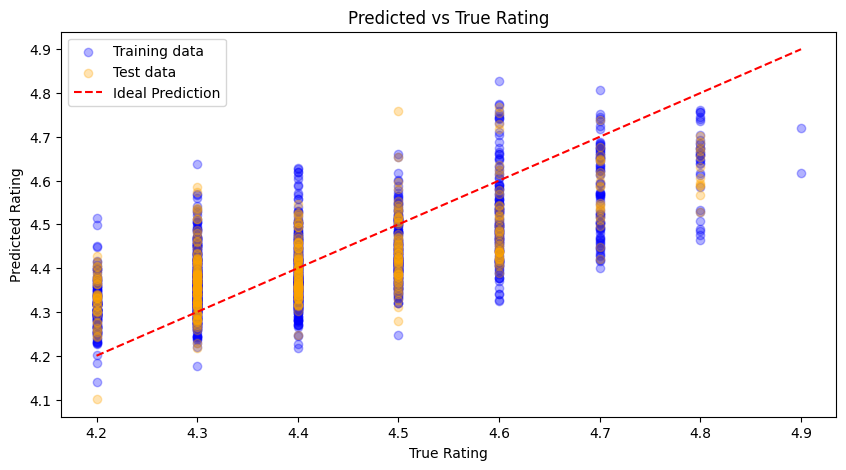

In [93]:
# Create the feature and target dataframes

features_quality_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
df_features_quality = df[features_quality_columns]
print(df_features_quality.sample(10))
# I won't scale rating as the values are moderate
df_target_quality = df['rating']


# Use StandardScaler to scale the features

scaler_quality = StandardScaler()
scaler_quality.fit(df_features_quality)
df_features_quality_std = scaler_quality.transform(df_features_quality)

# Create test and training sets
# I will use 80% of the data for training and 20% for testing.

X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(df_features_quality_std, 
                                     df_target_quality,
                                     test_size=0.2, 
                                     random_state=0
                                     )

# Training the LinearRegression models.

lr_quality = LinearRegression()
lr_quality.fit(X_train_quality, y_train_quality)
# Make predictions on training and test sets.
y_pred_quality = lr_quality.predict(X_train_quality)
y_pred_quality_test = lr_quality.predict(X_test_quality)

# Evaluate the models using MAE, RMSE and R^2 score.
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
mae_quality = mean_absolute_error(y_train_quality, y_pred_quality)
rmse_quality = root_mean_squared_error(y_train_quality, y_pred_quality)
r2_quality = r2_score(y_train_quality, y_pred_quality)
# evaluate the test set as well
mae_quality_test = mean_absolute_error(y_test_quality, y_pred_quality_test)
rmse_quality_test = root_mean_squared_error(y_test_quality, y_pred_quality_test)
r2_quality_test = r2_score(y_test_quality, y_pred_quality_test)
# Print the evaluation metrics.
print("\nQuality Model Evaluation (Training Set):")
print(f"Mean Absolute Error (MAE): {mae_quality}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality}")
print(f"R^2 Score: {r2_quality}")
print("\nQuality Model Test Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_quality_test}")
print(f"Root Mean Squared Error (RMSE): {rmse_quality_test}")
print(f"R^2 Score: {r2_quality_test}")

# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10,5))
plt.scatter(y_train_quality, y_pred_quality, alpha=0.3, color='blue', label='Training data')
plt.scatter(y_test_quality, y_pred_quality_test, alpha=0.3, color='orange', label='Test data')
plt.plot([y_train_quality.min(), y_train_quality.max()], [y_train_quality.min(), y_train_quality.max()],  color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Rating')
plt.legend()
plt.show()  

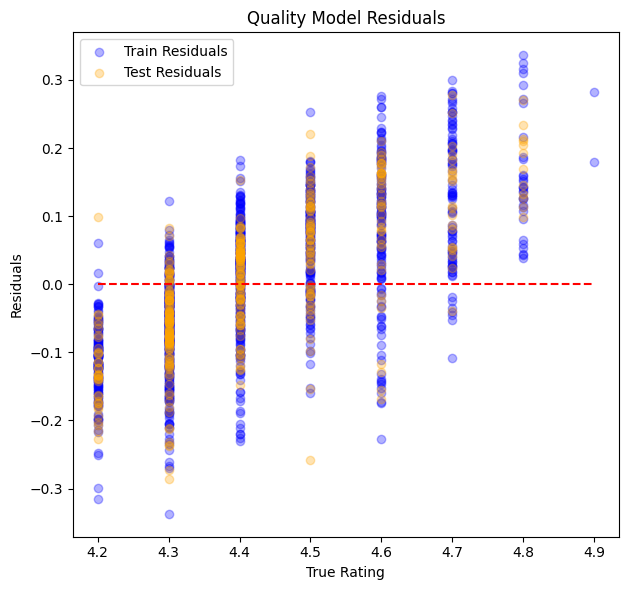

In [94]:
# Residual plots for both models to compare training and test residuals.
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 2)
plt.scatter(y_train_quality, y_train_quality - y_pred_quality, alpha=0.3, color='blue', label='Train Residuals')
plt.scatter(y_test_quality, y_test_quality - y_pred_quality_test, alpha=0.3, color='orange', label='Test Residuals')
plt.hlines(0, y_train_quality.min(), y_train_quality.max(), colors='red', linestyles='--')
plt.xlabel('True Rating')
plt.ylabel('Residuals')
plt.title('Quality Model Residuals')
plt.legend()

plt.tight_layout()
plt.show()


In [95]:
# I set up K-Fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store coefficients from each fold
coefs = []
 
# Target variable in a numpy array
y = df_target_quality.values

# Perform K-Fold cross-validation
for train_idx, test_idx in kf.split(df_features_quality_std):
    X_train, X_test = df_features_quality_std[train_idx], df_features_quality_std[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    coefs.append(model.coef_)

# Convert to DataFrame for analysis
coefs_df = pd.DataFrame(coefs, columns=features_quality_columns)

# Analyze mean and std deviation of coefficients across folds
coef_summary = pd.DataFrame({
    'mean_coef': coefs_df.mean(),
    'std_coef': coefs_df.std(),
    'abs_mean': coefs_df.mean().abs()
}).sort_values('abs_mean', ascending=False)

# Calculate the coefficient of variation for each model coefficient (i.e. for each feature)
# by dividing the standard deviation of the coefficients by the absolute means (i.e. the variations across the folds).
# Add a small number (epsilon) just so there is no division by zero
epsilon = 1e-6
cv = coef_summary['std_coef'] / (coef_summary['abs_mean'] + epsilon)
# for each feature, check if the feature coefficient does not always have the same sign across the folds.
sign_flips = coefs_df.apply(np.sign, axis=0).nunique() > 1

# Define thresholds for stability
# cv: if cv >1, the variance is higher than the mean, so the feature is unstable
# abs_mean: if the abs(coefficient) is very small, the feature is not important
cv_threshold = 1.0
abs_mean_threshold = 0.01

# Calculate stability mask:
# cv under the threshold, abs_mean above the threshold, and no sign flips
stable_mask = (cv < cv_threshold) & (coef_summary['abs_mean'] > abs_mean_threshold) & (~sign_flips)

# Add Stable column
coef_summary['Stable'] = stable_mask

print("RESULTS FOR QUALITY MODEL\n")
pd.set_option('display.max_rows', 1300)  # Or use 1250 exactly

print(coef_summary)


RESULTS FOR QUALITY MODEL

                           mean_coef  std_coef  abs_mean  Stable
price_log                   0.116888  0.002347  0.116888    True
type_Priorat Red           -0.037563  0.031525  0.037563   False
age_log                    -0.025685  0.001209  0.025685    True
region_Rioja               -0.017350  0.001167  0.017350    True
region_Priorato             0.016953  0.031805  0.016953   False
is_nv                      -0.006347  0.001261  0.006347   False
region_Ribera del Duero     0.005754  0.003349  0.005754   False
type_Ribera Del Duero Red  -0.004247  0.004886  0.004247   False
body                        0.003377  0.001239  0.003377   False
type_Rioja Red              0.003220  0.001794  0.003220   False
type_Red                   -0.001215  0.001367  0.001215   False
